In [1]:
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
from ast import literal_eval
from dotenv import load_dotenv 
import os
from PIL import Image

In [2]:
# loading variables from .env file
load_dotenv("../../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
RECORD_IDS_TRAINING_SET = PARENT + os.getenv("RECORD_IDS_TRAINING_SET")

WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
WRITTEN_CAPTIONS_TRAINING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TRAINING_SET")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")

BENCHMARK_1 = PARENT + os.getenv("BENCHMARK_1")

In [3]:
def fixPath(path):
    return path.replace(".././", "../")

filtered_data_downloaded = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)

def get_image_path_from_recordID(recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = filtered_data_downloaded[
        filtered_data_downloaded["recordID"] == recordID
    ]["low_res_filename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

In [4]:
# Get the artworks data
ARTWORKS = pd.read_csv(DB_INPUT_ARTPIECES)
ARTWORKS.head(1)

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,physicalAppearanceDescription,imageType,imageColor,imageLowResFilename,imageHighResFilename,imageCopyright,formalDescriptionTermStylesPeriods,height,width,ratio
0,64,8181,Auth:509:309,fre,La Crucifixion,détrempe,peinture (Dept. Art Ancien),toile|tempera,NaN,1460.0,...,Tempera sur toile,digitale JPG,photo couleurs,/art-foto/old/internet/Bouts-8181dig-L.jpg,/art-foto/old/intranet/Bouts-8181dig-H.jpg,NaN,Primitifs flamands,181.5,153.5,0.84573


In [5]:
# Get the artworks data
ARTISTS = pd.read_csv(DB_INPUT_ARTISTS)
ARTISTS.head(1)

,creatorID,creatorLastName,creatorFirstName,creatorBirthAndDeathDescription,creatorNationality,creatorDeathDate,creatorBirthDate
0,Auth:509:309,Bouts,Dirk,Haarlem (Pays-Bas) vers 1410 ? - Louvain 1475,NaN,1475.0,1410.0


In [6]:
def v_literal_eval(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return np.nan
DATA = pd.read_csv(BENCHMARK_1, converters={'additional_info_fr': v_literal_eval, 'additional_info_en': v_literal_eval, 'additional_info_nl': v_literal_eval})
unique_focus = DATA['focus'].unique()
example_df = None
for focus in unique_focus:
    focus_data = DATA[DATA['focus'] == focus]
    if example_df is None:
        example_df = focus_data.sample(1)
    else:
        example_df = pd.concat([example_df, focus_data.sample(1)], ignore_index=True)

example_df.drop(columns=['tokenized_length_fr', 'tokenized_length_en', 'tokenized_length_nl'], inplace=True)
for i, val in enumerate(example_df.iloc[0]):
    col = example_df.columns[i]
    print(f"{col}: {val}")

recordID: 7743
category: Dessin
focus: colors
caption_fr: Portrait d'une femme avec une hotte sur la tête, chapeau, colier
caption_en: Portrait of a woman with a hood on her head, hat, hummingbird
caption_nl: Portret van een vrouw met een kap op haar hoofd, hoed, kolibrie
additional_info_fr: ['Couleur noir et blanc']
additional_info_en: ['Black and white color']
additional_info_nl: ['Zwart-wit kleur']


In [7]:
artworks_recordIDs = sorted(list(DATA['recordID'].unique()))
print(len(artworks_recordIDs))

454


In [8]:
import pickle
models_name = [
    "basic-mini",
    "basic-base",
    "basic-large",
    "february_finetuned",
    "march_finetuned",
    "art-mini",
    "art-base",
    "art-large",
]
data = {}
for model_name in models_name:
    data[model_name] = {}
    data[model_name]["metrics"] = pd.read_csv(f"../../benchmarks/benchmark_1/{model_name}_benchmark.csv")
    data[model_name]["positions"] = {
        "-PROMPT": pickle.load(open(f"../../benchmarks/benchmark_1/{model_name}_positions_prompt.pkl", "rb")),
        "-MIXED": pickle.load(open(f"../../benchmarks/benchmark_1/{model_name}_positions_mixed.pkl", "rb")),
    }

data["art-base"]["metrics"]

,variant,lang,focus,average_position,mrr,recall@1,recall@3,recall@5,recall@10,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,-PROMPT,en,colors,1.770925,0.846736,0.757709,0.925110,0.964758,0.982379,0.757709,0.857848,0.874248,0.879690
1,-PROMPT,en,content,1.667401,0.851465,0.764317,0.927313,0.958150,0.986784,0.764317,0.861965,0.874860,0.884362
2,-PROMPT,en,emotion,1.762115,0.834438,0.735683,0.933921,0.953744,0.984581,0.735683,0.852682,0.861027,0.871084
3,-PROMPT,en,luminosity,1.837004,0.833300,0.740088,0.914097,0.949339,0.980176,0.740088,0.844108,0.858513,0.868628
4,-PROMPT,fr,colors,2.768722,0.778216,0.667401,0.870044,0.927313,0.962555,0.667401,0.786891,0.810397,0.822039
5,-PROMPT,fr,content,2.497797,0.778486,0.667401,0.863436,0.914097,0.962555,0.667401,0.785318,0.806171,0.822161
6,-PROMPT,fr,emotion,2.737885,0.771299,0.660793,0.854626,0.911894,0.953744,0.660793,0.776743,0.800539,0.814339
7,-PROMPT,fr,luminosity,2.781938,0.758006,0.640969,0.856828,0.900881,0.955947,0.640969,0.768798,0.786998,0.804634
8,-PROMPT,nl,colors,5.374449,0.673865,0.544053,0.768722,0.841410,0.903084,0.544053,0.676575,0.705756,0.725804
9,-PROMPT,nl,content,5.039648,0.662191,0.535242,0.751101,0.821586,0.911894,0.535242,0.659899,0.689096,0.719087


In [9]:
def getdf(model_name, focus=None):
    if focus is None:
        df = data[model_name]["metrics"] 
    else:
        df = data[model_name]["metrics"][data[model_name]["metrics"]["focus"] == focus]
    df["model_name"] = model_name
    return df

def getjson(model_name, focus):
    if focus is None:
        positions_merged = {}
        for lang in data[model_name]["positions"]:
            positions_merged[lang] = []
            for focus in data[model_name]["positions"][lang]:
                positions_merged[lang].extend(data[model_name]["positions"][lang][focus])
        return positions_merged
    else:
        positions = {}
        for lang in data[model_name]["positions"]:
            positions[lang] = data[model_name]["positions"][lang][focus]
        return positions

def histogram_positions(model_name, focus):
    positions = getjson(model_name, focus)
    langs = list(positions.keys())
    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))
    for i, lang in enumerate(langs):
        axs[i].hist(positions[lang], bins=20, edgecolor='black')
        axs[i].set_title(lang)
        axs[i].set_xlabel("Position")
        axs[i].set_ylabel("Frequency")
    plt.suptitle(f"Histogram of positions for {model_name} and {focus}")
    plt.tight_layout()
    plt.show()

def cdf_positions(model_name, focus):
    positions = getjson(model_name, focus) 
    langs = list(positions.keys())

    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))

    if len(langs) == 1:
        axs = [axs]

    # Get overall max position
    max_position = 0
    for lang in langs:
        max_position = max(max_position, max(positions[lang]))

    for i, lang in enumerate(langs):
        data = np.sort(positions[lang])
        cdf = np.arange(1, len(data) + 1) / len(data)
        # Fill cdf with 1 so that the last point is at the max position
        
        while data[-1] < max_position:
            data = np.concatenate([data, [max_position]])
            cdf = np.concatenate([cdf, [1]])

        percentile_90 = np.percentile(data, 90)
        percentile_95 = np.percentile(data, 95)
        percentile_99 = np.percentile(data, 99)

        # Vlines for 90, 95, 99 percentile
        axs[i].vlines(percentile_90, 0, 1, color='r', linestyle='--', label='90th Percentile')
        axs[i].vlines(percentile_95, 0, 1, color='g', linestyle='--', label='95th Percentile')
        axs[i].vlines(percentile_99, 0, 1, color='y', linestyle='--', label='99th Percentile')
        

        axs[i].plot(data, cdf, linestyle='-', color='b', label='CDF')
        axs[i].set_title(lang)
        axs[i].set_xlabel("Position")
        axs[i].set_ylabel("Cumulative Frequency")
        axs[i].grid(True, linestyle='--', alpha=0.5)
        axs[i].set_xlim(0, max_position)
        axs[i].legend(loc='lower right')

    plt.suptitle(f"CDF of positions for {model_name} and {focus}")
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()

In [10]:
if False:
    # Add to the metrics the percentile 50, 90, 95, 99
    positions_per_model_per_lang = {}
    for model_name in models_name:
        positions_per_model_per_lang[model_name] = {}
        print("Done ", model_name)
        for focus in data[model_name]["metrics"]["focus"].unique():
            if focus=="all_focus":
                continue
            df = getdf(model_name, focus)

            json_data = getjson(model_name, focus)
            for lang in json_data.keys():
                positions = json_data[lang]
                # Create a boolean mask for the correct rows
                mask = (df["model_name"] == model_name) & (df["lang"] == lang)
                # Apply the mask to update the percentiles
                df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
                df.loc[mask, "percentile_75"] = np.percentile(positions, 75)
                df.loc[mask, "percentile_90"] = np.percentile(positions, 90)
                df.loc[mask, "percentile_95"] = np.percentile(positions, 95)
                df.loc[mask, "percentile_99"] = np.percentile(positions, 99)

        # Add for all_focus
        df = getdf(model_name, None)
        json_data = getjson(model_name, None)
        for lang in json_data.keys():
            positions = json_data[lang]
            positions_per_model_per_lang[model_name][lang] = positions
            # Create a boolean mask for the correct rows
            mask = (df["model_name"] == model_name) & (df["lang"] == lang)
            # Apply the mask to update the percentiles
            df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
            df.loc[mask, "percentile_75"] = np.percentile(positions, 75)
            df.loc[mask, "percentile_90"] = np.percentile(positions, 90)
            df.loc[mask, "percentile_95"] = np.percentile(positions, 95)
            df.loc[mask, "percentile_99"] = np.percentile(positions, 99)

In [11]:
for model_name in models_name:
    df = data[model_name]["metrics"]
    if "mean" in df["focus"].unique():
        continue
    for variant in df["variant"].unique():
        df_variant = df[df["variant"] == variant]
        for lang in df_variant["lang"].unique():
            df_variant_lang = df_variant[df_variant["lang"] == lang]
            df.loc[len(df)] = [
                variant,
                lang,
                "mean",
                df_variant_lang["average_position"].mean(),
                df_variant_lang["mrr"].mean(),
                df_variant_lang["recall@1"].mean(),
                df_variant_lang["recall@3"].mean(),
                df_variant_lang["recall@5"].mean(),
                df_variant_lang["recall@10"].mean(),
                df_variant_lang["nDCG@1"].mean(),
                df_variant_lang["nDCG@3"].mean(),
                df_variant_lang["nDCG@5"].mean(),
                df_variant_lang["nDCG@10"].mean(),
            ]

ex = data["art-base"]["metrics"]
ex.loc[ex["focus"]=="mean"]

,variant,lang,focus,average_position,mrr,recall@1,recall@3,recall@5,recall@10,nDCG@1,nDCG@3,nDCG@5,nDCG@10
21,-PROMPT,en,mean,1.759361,0.841485,0.749449,0.925110,0.956498,0.983480,0.749449,0.854151,0.867162,0.875941
22,-PROMPT,fr,mean,2.696586,0.771502,0.659141,0.861233,0.913546,0.958700,0.659141,0.779437,0.801026,0.815793
23,-PROMPT,nl,mean,5.307819,0.662497,0.535793,0.752753,0.821586,0.904185,0.535793,0.662009,0.690278,0.717176
24,-MIXED,en,mean,2.933921,0.740228,0.625551,0.824523,0.893539,0.949339,0.625551,0.742340,0.770809,0.789016
25,-MIXED,fr,mean,4.359765,0.680830,0.557269,0.759178,0.832599,0.908957,0.557269,0.676969,0.707624,0.732503
26,-MIXED,nl,mean,9.096182,0.561993,0.429515,0.635095,0.726872,0.823789,0.429515,0.549705,0.587268,0.618637


In [12]:
# Merge all the dataframes
df_all = pd.DataFrame()
for model_name in models_name:
    df = data[model_name]["metrics"]
    df["model_name"] = model_name
    df_all = pd.concat([df_all, df], ignore_index=True)

df_all

,variant,lang,focus,average_position,mrr,recall@1,recall@3,recall@5,recall@10,nDCG@1,nDCG@3,nDCG@5,nDCG@10,model_name
0,-PROMPT,en,colors,6.671806,0.608700,0.491189,0.667401,0.755507,0.841410,0.491189,0.594292,0.630403,0.658281,basic-mini
1,-PROMPT,en,content,7.559471,0.578052,0.447137,0.647577,0.742291,0.832599,0.447137,0.565525,0.604386,0.633656,basic-mini
2,-PROMPT,en,emotion,7.378855,0.557076,0.416300,0.638767,0.726872,0.832599,0.416300,0.546567,0.582774,0.617221,basic-mini
3,-PROMPT,en,luminosity,7.559471,0.565926,0.436123,0.623348,0.720264,0.810573,0.436123,0.548770,0.588289,0.617326,basic-mini
4,-PROMPT,fr,colors,18.632159,0.367949,0.240088,0.394273,0.519824,0.636564,0.240088,0.331023,0.382392,0.420411,basic-mini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,-PROMPT,fr,mean,2.838656,0.766068,0.656388,0.849119,0.910793,0.957048,0.656388,0.770417,0.795965,0.811099,art-large
212,-PROMPT,nl,mean,5.459251,0.657025,0.523128,0.754956,0.814978,0.903634,0.523128,0.659229,0.683945,0.712911,art-large
213,-MIXED,en,mean,3.096182,0.746942,0.637298,0.825991,0.886197,0.945668,0.637298,0.748948,0.773719,0.792958,art-large
214,-MIXED,fr,mean,4.683554,0.672407,0.551395,0.750367,0.830396,0.906755,0.551395,0.667896,0.700658,0.725193,art-large


In [13]:
lang_to_label = {
    "fr": "French",
    "en": "English",
    "nl": "Dutch",
}

In [14]:
roundFactor = 4

Figure saved to:  ./../../.././public/figures/tri_mrr_per_lang.pdf


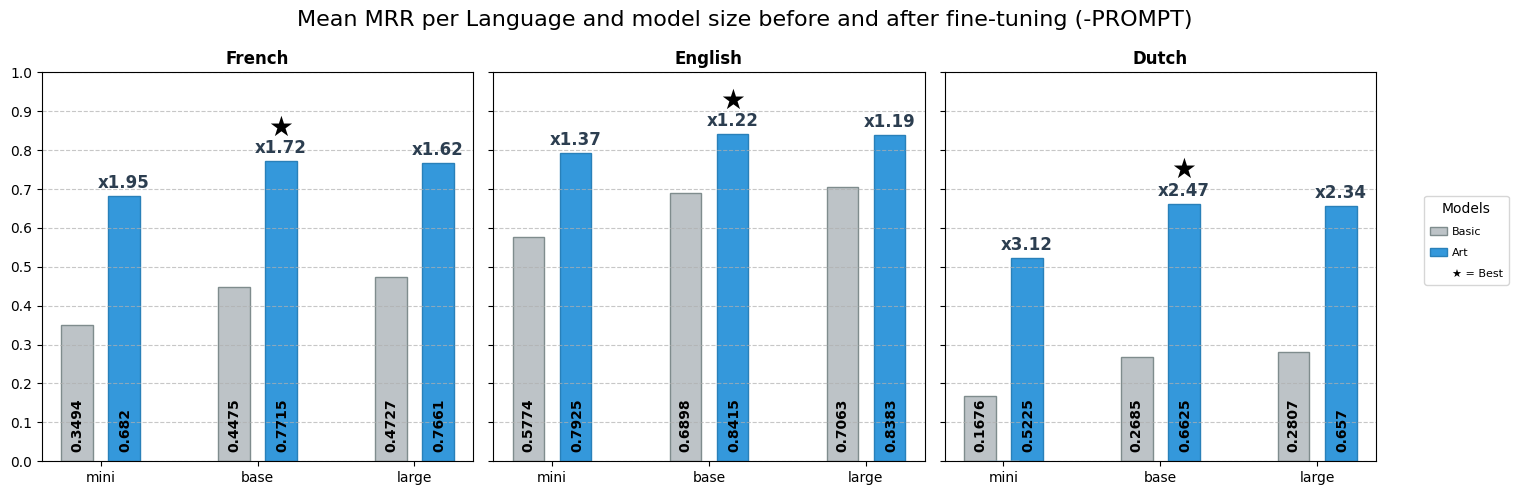

In [15]:
# Average mrr per lang  
df_all_mrr = df_all[df_all["focus"] == "mean"]
df_all_mrr = df_all_mrr[df_all_mrr["variant"]=="-PROMPT"]
df_all_mrr = df_all_mrr[["lang", "mrr", "model_name"]]
df_all_mrr = df_all_mrr.groupby(["lang", "model_name"]).mean().reset_index()
df_all_mrr = df_all_mrr.pivot(index="lang", columns="model_name", values="mrr")

# Reorder the columns model_name such that it follows the order in models_name
df_all_mrr = df_all_mrr.reindex(columns=models_name)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

best_size_per_lang = {}
for langIndex, lang in enumerate(["fr", "en", "nl"]):
    art_result_for_lang = df_all_mrr.loc[lang][["art-mini", "art-base", "art-large"]]
    best_mrr = art_result_for_lang.max()
    best_model_size = art_result_for_lang.idxmax()
    best_size_per_lang[lang] = best_model_size

for langIndex, lang in enumerate(["fr", "en", "nl"]):
    result_for_lang = df_all_mrr.loc[lang]
    
    ax = axs[langIndex]

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for model_size_x, model_size in enumerate(["mini", "base", "large"]):
        base_result = result_for_lang[f"basic-{model_size}"]
        art_result = result_for_lang[f"art-{model_size}"]

        isArtBest = best_size_per_lang[lang] == f"art-{model_size}"

        ax.bar(
            model_size_x - 0.15,
            base_result,
            width=0.2,
            color="#bdc3c7",
            edgecolor="#7f8c8d"
        )
        # Add the value at the bottom of the bar
        ax.text(
            model_size_x - 0.15,
            0.025,
            str(round(base_result, roundFactor)),
            ha='center',
            va='bottom',
            fontsize=10,
            color="black",
            rotation=90,
            fontweight='bold'
        )

        ax.bar(
            model_size_x + 0.15,
            art_result,
            width=0.2,
            color="#3498db",
            edgecolor="#2980b9",
        )
        # Add the value at the bottom of the bar
        ax.text(
            model_size_x + 0.16,
            0.025,
            str(round(art_result, roundFactor)),
            ha='center',
            va='bottom',
            fontsize=10,
            color="black",
            rotation=90,
            fontweight='bold',
        )
        # Add a star above the bar if art_result is the best
        if isArtBest:
            ax.text(
                model_size_x + 0.15,
                art_result + 0.05,
                "★",
                ha='center',
                va='bottom',
                fontsize=20,
                color="black",
                fontweight='bold'
            )

        # Add a text above the art_result bar
        xDifference = round(art_result/base_result, 2)
        xDifference = f"x{xDifference}"
        ax.text(
            model_size_x + 0.15,
            art_result + 0.01,
            xDifference,
            ha='center',
            va='bottom',
            fontsize=12,
            color="#2c3e50",
            fontweight='bold'
        )


    ax.set_title(lang_to_label[lang], fontsize=12, fontweight='bold')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["mini", "base", "large"])
    ax.set_ylim(0, 1)

    y_ticks = np.arange(0, 1.1, 0.1)
    ax.set_yticks(y_ticks)

ax = axs[2]
ax.bar(0,0, width=0.2, color="#bdc3c7", edgecolor="#7f8c8d", label="Basic")
ax.bar(0,0, width=0.2, color="#3498db", edgecolor="#2980b9", label="Art")
# Add a label for the star
ax.bar(0,0, width=0.2, color="#fff", edgecolor="#fff", label="★ = Best")

ax.legend(
    loc="lower right",
    fontsize=8,
    title="Models",
    markerscale=1.5,
    handlelength=1.5,
    handletextpad=0.5,
    borderpad=0.5,
    labelspacing=1,
    bbox_to_anchor=(1.32, 0.44)
)

plt.suptitle("Mean MRR per Language and model size before and after fine-tuning (-PROMPT)", fontsize=16)
plt.tight_layout()
plt.savefig(FOLDER_FIGURES + "tri_mrr_per_lang.pdf", dpi=300)
print("Figure saved to: ", FOLDER_FIGURES + "tri_mrr_per_lang.pdf")
plt.show()

In [16]:
# Mrr evolution with the addition of additional information

# Average mrr per lang  
df_spec_mrr = df_all[df_all["variant"]=="-PROMPT"]
df_spec_mrr = df_spec_mrr[["lang", "model_name", "focus", "mrr"]]


langs = ["en", "fr", "nl"]
selected_model_names = ["basic-mini", "basic-base", "basic-large", "art-mini", "art-base", "art-large"]

additional_info_table_per_lang = {}

for langIndex, lang in enumerate(langs):

    additional_info_table_for_lang = {}

    additional_info_table = pd.DataFrame(columns=[
        "Model",
        "Finetuned",
        "Additional information",
        "MRR without additional information",
        "MRR with additional information",
        "Difference (absolute)",
        "Difference (%)"
    ])

    rowInLang = df_spec_mrr.loc[df_spec_mrr["lang"] == lang]
    focuses = list(rowInLang["focus"].unique())
    focuses.remove("content")
    focuses.remove("mean")

    for model_name_index, model_name in enumerate(selected_model_names):

        rowForModelSize = rowInLang.loc[rowInLang["model_name"] == model_name]
        isFinetune = "art" in model_name

        mrr_without_additional_info = rowForModelSize.loc[rowForModelSize["focus"] == "content"]["mrr"].values[0]
        for focus in focuses:
            mrr_with_additional_info = rowForModelSize.loc[rowForModelSize["focus"] == focus]["mrr"].values[0]
            additional_info = focus.replace("content-", "")
            # Add the row to the table
            additional_info_table.loc[len(additional_info_table)] = [
                model_name,
                isFinetune,
                additional_info,
                mrr_without_additional_info,
                mrr_with_additional_info,
                mrr_with_additional_info - mrr_without_additional_info,
                (mrr_with_additional_info - mrr_without_additional_info) / mrr_without_additional_info * 100
            ]

    additional_info_table_for_lang["details"] = additional_info_table

    # Compute the mean of the difference per model name
    additional_info_table_per_model_name = pd.DataFrame(columns=[
        "Model",
        "Finetuned",
        "MRR without additional information",
        "MRR with additional information",
        "Difference (absolute)",
        "Difference (%)"
    ])
    for model_name in selected_model_names:
        isFinetune = "art" in model_name
        rowForModelSize = additional_info_table.loc[additional_info_table["Model"] == model_name]
        rowForModelSize = rowForModelSize.loc[rowForModelSize["Finetuned"] == isFinetune]

        mrr_without_additional_info = rowForModelSize["MRR without additional information"].mean()
        mrr_with_additional_info = rowForModelSize["MRR with additional information"].mean()
        additional_info_table_per_model_name.loc[len(additional_info_table_per_model_name)] = [
            model_name,
            isFinetune,
            mrr_without_additional_info,
            mrr_with_additional_info,
            mrr_with_additional_info - mrr_without_additional_info,
            (mrr_with_additional_info - mrr_without_additional_info) / mrr_without_additional_info * 100
        ]
    additional_info_table_for_lang["per_model_name"] = additional_info_table_per_model_name

    # Compute the mean of the difference per focus
    additional_info_table_per_focus = pd.DataFrame(columns=[
        "Additional information",
        "Finetuned",
        "MRR without additional information",
        "MRR with additional information",
        "Difference (absolute)",
        "Difference (%)"
    ])

    for focus in focuses:

        for isFinetune in [False, True]:
            rowForFocus = additional_info_table.loc[additional_info_table["Additional information"] == focus]
            rowForFocus = rowForFocus.loc[rowForFocus["Finetuned"] == isFinetune]

            mrr_without_additional_info = rowForFocus["MRR without additional information"].mean()
            mrr_with_additional_info = rowForFocus["MRR with additional information"].mean()
            additional_info_table_per_focus.loc[len(additional_info_table_per_focus)] = [
                focus,
                isFinetune,
                mrr_without_additional_info,
                mrr_with_additional_info,
                mrr_with_additional_info - mrr_without_additional_info,
                (mrr_with_additional_info - mrr_without_additional_info) / mrr_without_additional_info * 100
            ]

    additional_info_table_for_lang["per_focus"] = additional_info_table_per_focus

    additional_info_table_per_lang[lang] = additional_info_table_for_lang

additional_info_table_per_lang["fr"]["details"]

,Model,Finetuned,Additional information,MRR without additional information,MRR with additional information,Difference (absolute),Difference (%)
0,basic-mini,False,colors,0.343672,0.367949,0.024277,7.064080
1,basic-mini,False,emotion,0.343672,0.341441,-0.002231,-0.649166
2,basic-mini,False,luminosity,0.343672,0.344679,0.001007,0.293045
3,basic-base,False,colors,0.444539,0.466126,0.021587,4.856063
4,basic-base,False,emotion,0.444539,0.449694,0.005155,1.159669
5,basic-base,False,luminosity,0.444539,0.429657,-0.014882,-3.347642
6,basic-large,False,colors,0.482834,0.478826,-0.004008,-0.830061
7,basic-large,False,emotion,0.482834,0.479492,-0.003342,-0.692095
8,basic-large,False,luminosity,0.482834,0.449691,-0.033143,-6.864269
9,art-mini,True,colors,0.684487,0.704945,0.020459,2.988916


In [17]:
additional_info_table_per_lang["fr"]["per_model_name"]

,Model,Finetuned,MRR without additional information,MRR with additional information,Difference (absolute),Difference (%)
0,basic-mini,False,0.343672,0.351356,0.007684,2.235986
1,basic-base,False,0.444539,0.448493,0.003954,0.889363
2,basic-large,False,0.482834,0.469337,-0.013498,-2.795475
3,art-mini,True,0.684487,0.681170,-0.003317,-0.484610
4,art-base,True,0.778486,0.769174,-0.009312,-1.196153
5,art-large,True,0.782935,0.760446,-0.022489,-2.872396


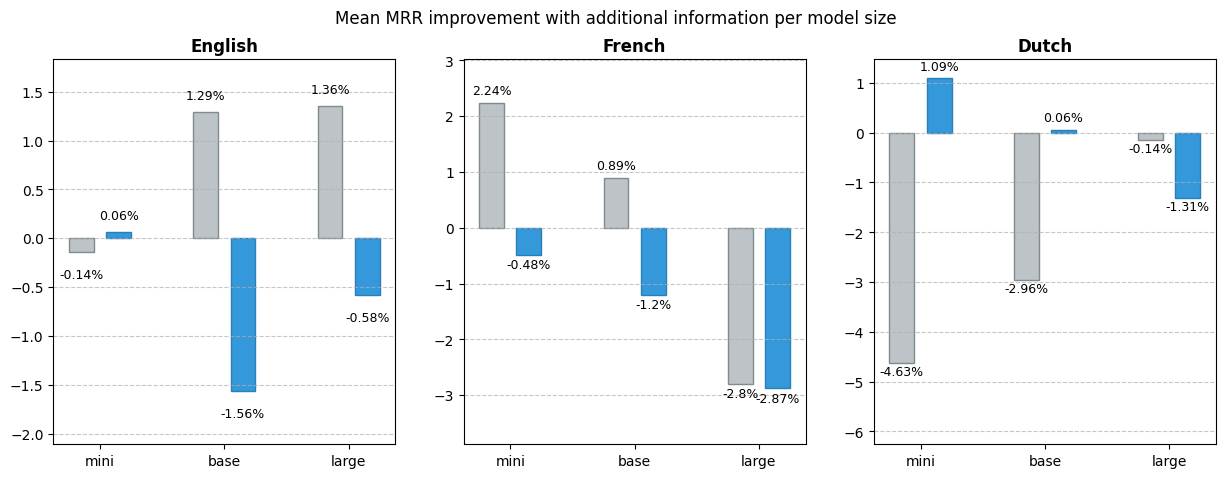

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for langIndex, lang in enumerate(langs):
    result_for_lang = additional_info_table_per_lang[lang]["per_model_name"]

    ax = axs[langIndex]

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for model_size_x, model_size in enumerate(["mini", "base", "large"]):
        base_result = result_for_lang.loc[result_for_lang["Model"] == f"basic-{model_size}"]["Difference (%)"].values[0]
        art_result = result_for_lang.loc[result_for_lang["Model"] == f"art-{model_size}"]["Difference (%)"].values[0]
        ax.bar(
            model_size_x - 0.15,
            base_result,
            width=0.2,
            label=f"basic-{model_size}",
            color="#bdc3c7",
            edgecolor="#7f8c8d"
        )
        ax.text(
            model_size_x - 0.15,
            base_result + (-0.30 if base_result < 0 else 0.10),
            f"{round(base_result, 2)}%",
            ha='center',
            va='bottom',
            fontsize=9,
            color="black"
        )

        ax.bar(
            model_size_x + 0.15,
            art_result,
            width=0.2,
            label=f"art-{model_size}",
            color="#3498db",
            edgecolor="#2980b9"
        )
        ax.text(
            model_size_x + 0.15,
            art_result + (-0.30 if art_result < 0 else 0.10),
            f"{round(art_result, 2)}%",
            ha='center',
            va='bottom',
            fontsize=9,
            color="black"
        )


    minVal = min(result_for_lang["Difference (%)"])
    maxVal = max(result_for_lang["Difference (%)"])
    
    a = 0.35
    minLimit = minVal*(1+a) if minVal < 0 else minVal*(1-a)
    maxLimit = maxVal*(1+a)
    ax.set_ylim(minLimit, maxLimit)

    ax.set_title(lang_to_label[lang], fontsize=12, fontweight='bold')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["mini", "base", "large"])

plt.suptitle("Mean MRR improvement with additional information per model size")
plt.show()

In [19]:
additional_info_table_per_lang["fr"]["per_focus"]

,Additional information,Finetuned,MRR without additional information,MRR with additional information,Difference (absolute),Difference (%)
0,colors,False,0.423682,0.437634,0.013952,3.293079
1,colors,True,0.748636,0.750113,0.001477,0.197330
2,emotion,False,0.423682,0.423542,-0.000139,-0.032846
3,emotion,True,0.748636,0.741700,-0.006935,-0.926390
4,luminosity,False,0.423682,0.408009,-0.015672,-3.699122
5,luminosity,True,0.748636,0.718976,-0.029660,-3.961868


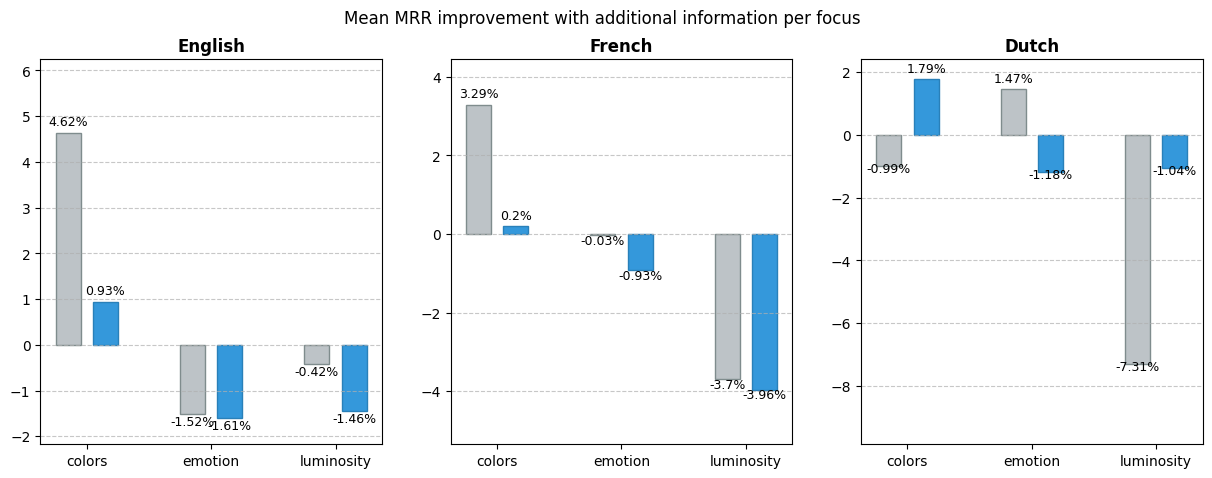

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for langIndex, lang in enumerate(langs):
    result_for_lang = additional_info_table_per_lang[lang]["per_focus"]

    ax = axs[langIndex]

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    

    for focus_index, focus in enumerate(result_for_lang["Additional information"].unique()):
        rowsForFocus = result_for_lang.loc[result_for_lang["Additional information"] == focus]

        base_result = rowsForFocus.loc[rowsForFocus["Finetuned"] == False]["Difference (%)"].values[0]
        art_result = rowsForFocus.loc[rowsForFocus["Finetuned"] == True]["Difference (%)"].values[0]
        ax.bar(
            focus_index - 0.15,
            base_result,
            width=0.2,
            label=f"basic-{focus}",
            color="#bdc3c7",
            edgecolor="#7f8c8d"
        )
        ax.text(
            focus_index - 0.15,
            base_result + (-0.30 if base_result < 0 else 0.10),
            f"{round(base_result, 2)}%",
            ha='center',
            va='bottom',
            fontsize=9,
            color="black"
        )

        ax.bar(
            focus_index + 0.15,
            art_result,
            width=0.2,
            label=f"art-{focus}",
            color="#3498db",
            edgecolor="#2980b9"
        )
        ax.text(
            focus_index + 0.15,
            art_result + (-0.30 if art_result < 0 else 0.10),
            f"{round(art_result, 2)}%",
            ha='center',
            va='bottom',
            fontsize=9,
            color="black"
        )

    minVal = min(result_for_lang["Difference (%)"])
    maxVal = max(result_for_lang["Difference (%)"])

    a = 0.35
    minLimit = minVal*(1+a) if minVal < 0 else minVal*(1-a)
    maxLimit = maxVal*(1+a)
    ax.set_ylim(minLimit, maxLimit)
    ax.set_title(lang_to_label[lang], fontsize=12, fontweight='bold')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(result_for_lang["Additional information"].unique())

plt.suptitle("Mean MRR improvement with additional information per focus")
plt.show()

In [21]:
import write_latex as WL

def get_table_lang(lang, variant):
    table_LANG = df_all.loc[df_all["lang"] == lang]
    table_LANG = table_LANG.loc[table_LANG["variant"] == variant]
    table_LANG = table_LANG.loc[table_LANG["focus"] == "mean"]
    # Remove columns
    table_LANG = table_LANG.drop(columns=["lang", "focus", "nDCG@1"])
    # Columns for training_data
    table_LANG["training_data"] = [
        "N/A",
        "N/A",
        "N/A",
        "cap-FR-1",
        "cap-FR-2 \& ico-FR",
        "cap-TRI \& ico-TRI",
        "cap-TRI \& ico-TRI",
        "cap-TRI \& ico-TRI",
    ]
    table_LANG["pretrained_model"] = [
        "B/32",
        "L/14",
        "L/14@336px",
        "L/14",
        "L/14",
        "B/32",
        "L/14",
        "L/14@336px",
    ]
    # Round specific columns
    round_factor = 3
    numeric_columns = [
        "average_position",
        "mrr",
        "recall@1",
        "recall@3",
        "recall@5",
        "recall@10",
        "recall@3",
        "nDCG@5",
        "nDCG@3",
        "nDCG@10",
    ]
    for col in numeric_columns:
        table_LANG[col] = table_LANG[col].round(round_factor)
        if col == "average_position":
            best_value = table_LANG[col].min()
        else:
            best_value = table_LANG[col].max() 
        
        # Bold the value if it is the best in the column
        table_LANG[col] = table_LANG[col].apply(lambda x: f"\\textbf{{{x}}}" if x == best_value else str(x))
    # For each numeric column, bold the value
    # Reorder columns
    table_LANG = table_LANG[["training_data", "pretrained_model", "model_name", "average_position", "mrr", "recall@1", "recall@3", "recall@5", "recall@10", "nDCG@3", "nDCG@5", "nDCG@10"]]
    # Rename columns
    table_LANG = table_LANG.rename(columns={
        "training_data": "Dataset",
        "pretrained_model": "ViT",
        "model_name": "Model",
        "average_position": "Avg. Pos.",
        "mrr": "MRR",
        "recall@1": "Recall@1",
        "recall@3": "Recall@3",
        "recall@5": "Recall@5",
        "recall@10": "Recall@10",
        "nDCG@3": "nDCG@3",
        "nDCG@5": "nDCG@5",
        "nDCG@10": "nDCG@10",
    })
    # drop index
    table_LANG = table_LANG.reset_index(drop=True)
    return table_LANG

tables = {}
for lang in ["fr", "en", "nl"]:
    tables_lang = {}
    for variant in ["-PROMPT", "-MIXED"]:
        tables_lang[variant] = get_table_lang(lang, variant)
        tables_lang[variant].to_csv(f"../../CSV/table_{lang}_{variant}.csv", index=False)
    tables[lang] = tables_lang

print(WL.get_latex_summary_table(tables["nl"]["-MIXED"]))


        \begin{table}[]
        \centering
        \resizebox{\columnwidth}{!}{%
        \begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|}
        \hline
        \textbf{Dataset} & \textbf{ViT} & \textbf{Model} & \textbf{Avg. Pos.} & \textbf{MRR} & \textbf{Recall@1} & \textbf{Recall@3} & \textbf{Recall@5} & \textbf{Recall@10} & \textbf{nDCG@3} & \textbf{nDCG@5} & \textbf{nDCG@10} \\ \hline
        \multirow{3}{*}{N/A} & B/32 & basic-mini & 93.093 & 0.096 & 0.036 & 0.092 & 0.137 & 0.21 & 0.068 & 0.086 & 0.11 \\ \cline{2-12} 
        & L/14 & basic-base & 70.828 & 0.153 & 0.074 & 0.158 & 0.216 & 0.308 & 0.122 & 0.145 & 0.175 \\ \cline{2-12} 
        & L/14@336px & basic-large & 71.416 & 0.162 & 0.082 & 0.169 & 0.233 & 0.325 & 0.13 & 0.157 & 0.187 \\ \hline
        cap-FR-1 & \multirow{2}{*}{L/14} & february\_finetuned & 31.686 & 0.275 & 0.159 & 0.294 & 0.396 & 0.538 & 0.237 & 0.279 & 0.324 \\ \cline{1-1} \cline{3-12} 
        cap-FR-2 \& ico-FR &  & march\_finetuned & 27.313 & 0.343 & 0.219 & 

In [22]:
tables["fr"]["-PROMPT"].to_csv("../../CSV/table_fr_-PROMPT.csv", index=False)

In [23]:
tables["fr"]["-PROMPT"].columns

Index(['Dataset', 'ViT', 'Model', 'Avg. Pos.', 'MRR', 'Recall@1', 'Recall@3',
       'Recall@5', 'Recall@10', 'nDCG@3', 'nDCG@5', 'nDCG@10'],
      dtype='object')

In [24]:
# Get a table with the MRR for each model size
table_mrr = pd.DataFrame(columns=[
    "mini_MRR_basic", "mini_MRR_art", "mini_MRR_diff_prc", 
    "base_MRR_basic", "base_MRR_art", "base_MRR_diff_prc", 
    "large_MRR_basic", "large_MRR_art", "large_MRR_diff_prc"
])
variant = "-PROMPT"
for lang in ["fr", "en", "nl"]:
    table_LANG = df_all.loc[df_all["lang"] == lang]
    table_LANG = table_LANG.loc[table_LANG["variant"] == variant]
    table_LANG = table_LANG.loc[table_LANG["focus"] == "mean"]
    
    # Get the MRR for each model size
    mrr_mini_basic = table_LANG.loc[table_LANG["model_name"] == "basic-mini"]["mrr"].values[0]
    mrr_mini_art = table_LANG.loc[table_LANG["model_name"] == "art-mini"]["mrr"].values[0]
    mrr_base_basic = table_LANG.loc[table_LANG["model_name"] == "basic-base"]["mrr"].values[0]
    mrr_base_art = table_LANG.loc[table_LANG["model_name"] == "art-base"]["mrr"].values[0]
    mrr_large_basic = table_LANG.loc[table_LANG["model_name"] == "basic-large"]["mrr"].values[0]
    mrr_large_art = table_LANG.loc[table_LANG["model_name"] == "art-large"]["mrr"].values[0]

    # Add the row to the table
    print(mrr_mini_basic, mrr_mini_art)
    table_mrr.loc[len(table_mrr)] = [
        mrr_mini_basic,
        mrr_mini_art,
        (mrr_mini_art - mrr_mini_basic) / mrr_mini_basic * 100,
        mrr_base_basic,
        mrr_base_art,
        (mrr_base_art - mrr_base_basic) / mrr_base_basic * 100,
        mrr_large_basic,
        mrr_large_art,
        (mrr_large_art - mrr_large_basic) / mrr_large_basic * 100,
    ]

# Format the table
# Round each cell with "diff" to 4 decimal
colPercent = []
colOthers = []
for col in table_mrr.columns: 
    if "diff" in col:
        colPercent.append(col)
    else:
        colOthers.append(col)

for col in colPercent:
    table_mrr[col] = table_mrr[col].apply(lambda x: f"{round(x, 2)}%")

for col in colOthers:
    table_mrr[col] = table_mrr[col].apply(lambda x: f"{round(x, 4)}")

# save the table
table_mrr.to_csv(f"../../CSV/persize_table_mrr.csv", index=False)
print("Table saved to: ", "../../CSV/persize_table_mrr.csv")
table_mrr

0.3494348779440809 0.681998779028768
0.5774386302584369 0.7924552521216428
0.16756094904426794 0.5224663392014255
Table saved to:  ../../CSV/persize_table_mrr.csv


,mini_MRR_basic,mini_MRR_art,mini_MRR_diff_prc,base_MRR_basic,base_MRR_art,base_MRR_diff_prc,large_MRR_basic,large_MRR_art,large_MRR_diff_prc
0,0.3494,0.682,95.17%,0.4475,0.7715,72.4%,0.4727,0.7661,62.06%
1,0.5774,0.7925,37.24%,0.6898,0.8415,21.98%,0.7063,0.8383,18.69%
2,0.1676,0.5225,211.81%,0.2685,0.6625,146.75%,0.2807,0.657,134.04%


In [25]:
table = tables["en"]["-PROMPT"].copy()
# Remove rows Model= february_finetuned and march_finetuned
table = table[table["Model"] != "february_finetuned"]
table = table[table["Model"] != "march_finetuned"]
table

,Dataset,ViT,Model,Avg. Pos.,MRR,Recall@1,Recall@3,Recall@5,Recall@10,nDCG@3,nDCG@5,nDCG@10
0,N/A,B/32,basic-mini,7.292,0.577,0.448,0.644,0.736,0.829,0.564,0.601,0.632
1,N/A,L/14,basic-base,3.732,0.69,0.563,0.774,0.852,0.921,0.688,0.72,0.743
2,N/A,L/14@336px,basic-large,3.579,0.706,0.577,0.806,0.878,0.937,0.711,0.741,0.76
5,cap-TRI \& ico-TRI,B/32,art-mini,2.112,0.792,0.68,0.888,0.941,0.979,0.803,0.825,0.837
6,cap-TRI \& ico-TRI,L/14,art-base,\textbf{1.759},\textbf{0.841},\textbf{0.749},\textbf{\textbf{0.925}},\textbf{0.956},0.983,\textbf{0.854},\textbf{0.867},\textbf{0.876}
7,cap-TRI \& ico-TRI,L/14@336px,art-large,1.845,0.838,0.747,0.914,0.947,\textbf{0.985},0.848,0.861,0.874


In [26]:
def plot_metrics_per_model_per_lang(lang, variant):
    metrics = [
        "mrr",
        "recall@1",
        "recall@5",
        "recall@10",
        "nDCG@5",
        "nDCG@10"
    ]
    # 6 subplots, 1 row, 6 columns
    fig, axs = plt.subplots(2, 3, figsize=(20, 15))  

    fig.suptitle(f"Metrics for {lang} with the variant {variant}", fontsize=16)

    table_LANG = df_all.loc[df_all["lang"] == lang]
    table_LANG = table_LANG.loc[table_LANG["variant"] == variant]
    table_LANG = table_LANG.loc[table_LANG["focus"] == "mean"]
    
    # Iterate over the metrics and models
    for i, metric in enumerate(metrics):
        ax = axs[i // 3, i % 3] 
        bar_width = 0.8
        bar_positions = [0,1,2, 4,5, 7,8,9]

        bar_values = []
        for j, model_name in enumerate(models_name):
            df = table_LANG[table_LANG["model_name"] == model_name]
            if not df.empty:
                bar_values.append(df[metric].values[0])
            else:
                bar_values.append(0)
        
        best_value_index = np.argmax(bar_values)
        # Highlight the best value in the bar chart
        edge_colors = ["#ffffff"] * len(bar_values)
        edge_colors[best_value_index] = "#000"

        ax.bar(bar_positions, bar_values, width=bar_width, alpha=1.0, color=["#40739e", "#40739e", "#40739e", "#192a56", "#192a56", "#206915", "#8c6d15", "#8c2912"], label=metric, edgecolor=edge_colors, linewidth=3)
        # Add the value in the center (middle vertical) of the bar
        for j, value in enumerate(bar_values):
            ax.text(bar_positions[j], value/1.5, str(round(value, 3)), ha='center', va='bottom', fontsize=12, color='white', rotation=90, fontweight='bold')
        # Add a "BEST" label on the best bar
        ax.text(bar_positions[best_value_index], bar_values[best_value_index] + 0.02, "BEST", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
        ax.set_title(metric, fontsize=12)
        ax.set_xlabel("Model", fontsize=10)
        ax.set_ylabel(metric, fontsize=10)
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(models_name, rotation=45, ha="right", fontsize=8)
        ax.set_ylim(0, 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"../../figures/metrics_{lang}.pdf", dpi=300, bbox_inches='tight')

    plt.show()

if False:
    for lang in ["fr", "en", "nl"]:
        for variant in ["-PROMPT", "-MIXED"]:
            plot_metrics_per_model_per_lang(lang, variant)

# Qualitative results

In [27]:
selected_model_names = ["basic-mini",  "art-mini", "basic-base", "art-base", "basic-large", "art-large"]

nColumns = len(data["art-mini"]["positions"]["-PROMPT"][("en", "content")])
nRows = len(selected_model_names)


positions_merged_per_language = {}
for lang in ["en", "fr", "nl"]:
    positions_merged_per_language[lang] = {}
    for variant in ["-PROMPT", "-MIXED"]:    
        positions_merged_per_language[lang][variant] = {}

        focuses = ["content", "colors", "emotion", "luminosity"]
        if variant == "-MIXED":
            focuses.remove("content")

        for modelIndex, model_name in enumerate(selected_model_names):
            positions_merged_per_language[lang][variant][model_name] = {}
            for focusIndex, focus in enumerate(focuses):
                rowIndex = modelIndex*len(focuses) + focusIndex
                positions_for_model = data[model_name]["positions"][variant][(lang, focus)]
                positions_for_model = np.array(positions_for_model)
                size = positions_for_model.shape[0]

                # Compute the rank of each index
                ranks = []
                for index in range(size):
                    row = positions_for_model[index]
                    rank = np.where(row == index)[0][0] + 1
                    ranks.append(rank)
                
                ranks = np.array(ranks)
                positions_merged_per_language[lang][variant][model_name][focus] = ranks

len(positions_merged_per_language["en"]["-PROMPT"]["art-base"]["content"])

454

In [28]:
colorPerLang = {
    "en": "#3498db",
    "fr": "#e74c3c",
    "nl": "#2ecc71"
}
langToLabel = {
    "en": "English",
    "fr": "French",
    "nl": "Dutch"
}

splitAnalysis = pd.DataFrame(columns=[
    "Language", 
    "Model Size", 
    "First result", 
    "In the first 5", 
    "In the first 10", 
    "In the first 20",
]) 

variant = "-PROMPT"

for model_size in ["mini", "base", "large"]:
    for finetuned in [False, True]:
        model_name = f"art-{model_size}" if finetuned else f"basic-{model_size}"
        modelIndex = selected_model_names.index(model_name)
        for lang in ["en", "fr", "nl"]:
            positions = positions_merged_per_language[lang][variant][model_name]["content"]

            N = len(positions)
            splitAnalysis.loc[len(splitAnalysis)] = [
                langToLabel[lang],
                f"art-{model_size}" if finetuned else f"basic-{model_size}",
                len([x for x in positions if x <= 1])/N,
                len([x for x in positions if x <= 5])/N,
                len([x for x in positions if x <= 10])/N,
                len([x for x in positions if x <= 20])/N
            ]

splitAnalysis

,Language,Model Size,First result,In the first 5,In the first 10,In the first 20
0,English,basic-mini,0.447137,0.742291,0.832599,0.892070
1,French,basic-mini,0.226872,0.455947,0.572687,0.711454
2,Dutch,basic-mini,0.090308,0.246696,0.350220,0.442731
3,English,art-mini,0.678414,0.947137,0.982379,0.993392
4,French,art-mini,0.548458,0.859031,0.931718,0.962555
5,Dutch,art-mini,0.359031,0.691630,0.823789,0.907489
6,English,basic-base,0.546256,0.854626,0.911894,0.977974
7,French,basic-base,0.295154,0.625551,0.764317,0.845815
8,Dutch,basic-base,0.171806,0.370044,0.493392,0.623348
9,English,art-base,0.764317,0.958150,0.986784,1.000000


In [29]:
if False:
    variant = "-PROMPT"
    LANGS = ["en", "fr", "nl"]

    color_per_model_size = {
        "mini": "#3498db",
        "base": "#e74c3c",
        "large": "#2ecc71",
    }

    linestyle_per_finetuned = {
        True: "-",
        False: "--",
    }

    marker_per_finetuned = {
        True: "o",
        False: "x",
    }

    fig, axs = plt.subplots(1, 3, figsize=(17, 7), sharex=True)

    for langIndex, lang in enumerate(LANGS):
        ax = axs[langIndex]
        splitAnalysis_lang = splitAnalysis[splitAnalysis["Language"] == langToLabel[lang]]
        splitAnalysis_lang["TEMP_model_size"] = splitAnalysis_lang["Model Size"].apply(lambda x: x.split("-")[1])
        splitAnalysis_lang["TEMP_finetuned"] = splitAnalysis_lang["Model Size"].apply(lambda x: x.split("-")[0]== "art")
        for model_size in ["mini", "base", "large"]:
            # Get the data with model_size in the column "Model Size"
            splitAnalysis_lang_model_size = splitAnalysis_lang[splitAnalysis_lang["TEMP_model_size"] == model_size]
            for finetuned in [False, True]:
                splitAnalysis_lang_model_size_finetuned = splitAnalysis_lang_model_size[splitAnalysis_lang_model_size["TEMP_finetuned"] == finetuned].iloc[0]

                Xs = [
                    [1],
                    [5],
                    [10],
                    [20]
                ]

                #Xs = [
                #    [0],
                #    [1],
                #    [2],
                #    [3]
                #]

                # Add a rectangle hatched area for under 90%
                ax.fill_between(
                    [min_x, max_x],
                    -0.1,
                    0.9,
                    color="gray",
                    alpha=0.1,
                    hatch="\\"
                )

                # First result
                ax.plot(
                    Xs[0],
                    [splitAnalysis_lang_model_size_finetuned["First result"]],
                    marker=marker_per_finetuned[finetuned],
                    markersize=6,
                    color=color_per_model_size[model_size]
                )

                # In the first 5
                ax.plot(
                    Xs[1],
                    [splitAnalysis_lang_model_size_finetuned["In the first 5"]],
                    marker=marker_per_finetuned[finetuned],
                    markersize=6,
                    color=color_per_model_size[model_size],
                    linestyle=linestyle_per_finetuned[finetuned]
                )

                # In the first 10
                ax.plot(
                    Xs[2],
                    [splitAnalysis_lang_model_size_finetuned["In the first 10"]],
                    marker=marker_per_finetuned[finetuned],
                    markersize=6,
                    color=color_per_model_size[model_size],
                    linestyle=linestyle_per_finetuned[finetuned]
                )

                # In the first 20
                ax.plot(
                    Xs[3],
                    [splitAnalysis_lang_model_size_finetuned["In the first 20"]],
                    marker=marker_per_finetuned[finetuned],
                    markersize=6,
                    color=color_per_model_size[model_size],
                    linestyle=linestyle_per_finetuned[finetuned]
                )

                # Add a line between the points
                ax.plot(
                    Xs[0] + Xs[1] + Xs[2] + Xs[3],
                    [
                        splitAnalysis_lang_model_size_finetuned["First result"],
                        splitAnalysis_lang_model_size_finetuned["In the first 5"],
                        splitAnalysis_lang_model_size_finetuned["In the first 10"],
                        splitAnalysis_lang_model_size_finetuned["In the first 20"]
                    ],
                    linestyle=linestyle_per_finetuned[finetuned],
                    color=color_per_model_size[model_size],
                )

            ax.grid(True, linestyle='--', alpha=0.75)
            min_x = Xs[0][0]-0.25
            max_x = Xs[3][0]+0.25
            ax.set_xlim(min_x, max_x)
            ax.set_xticks(Xs[0] + Xs[1] + Xs[2] + Xs[3], labels=["=1", "<=5", "<=10", "<=20"], fontsize=8)
            ax.set_xticklabels(["=1", "<=5", "<=10", "<=20"], fontsize=8)
            ax.set_xlabel("Rank", fontsize=10)
            ax.set_ylabel("Percentage of tasks", fontsize=10)

            ax.set_ylim(-0.1, 1.1)
            ax.set_yticks(np.arange(0, 1.1, 0.1), labels=[f"{round(x*100)}%" for x in np.arange(0, 1.1, 0.1)])

            ax.set_title(langToLabel[lang], fontsize=12, fontweight='bold')

    # Add legend to the first subplot
    ax = axs[0]
    ax.bar(0, 0, color=color_per_model_size["mini"], label="mini")
    ax.bar(0, 0, color=color_per_model_size["base"], label="base")
    ax.bar(0, 0, color=color_per_model_size["large"], label="large")
    ax.plot(0, 0, color="black", linestyle="--", label="Not finetuned")
    ax.plot(0, 0, color="black", linestyle="-", label="Finetuned")
    ax.bar(0, 0, color="gray", alpha=0.1, hatch="\\", label="< 90% retrieval")

    ax.legend(
        loc="lower right",
        fontsize=8,
        markerscale=1.5,
        handlelength=1.5,
        handletextpad=0.5,
        borderpad=0.5,
        labelspacing=1,
    )

    plt.suptitle("Percentage of tasks in the first X results", fontsize=16)
    plt.show()  


In [30]:
def recordID_from_index(index):
    return artworks_recordIDs[index] 

def getDataFromRecordID(recordID):
    
    DB_entry = ARTWORKS.loc[ARTWORKS["recordID"] == recordID]

    # Get title
    title = DB_entry["title"].values[0]

    # Get creator
    creatorID = DB_entry["creatorID"].values[0]
    creatorDescription = DB_entry["creatorFullDescription"].values[0]
    
    if not pd.isna(creatorID):
        ARTIST_entry = ARTISTS.loc[ARTISTS["creatorID"] == DB_entry["creatorID"].values[0]]
        creatorFirstName = ARTIST_entry["creatorFirstName"].values[0]
        creatorLastName = ARTIST_entry["creatorLastName"].values[0]
        if not pd.isna(creatorFirstName) and not pd.isna(creatorLastName):
            creatorDescription = f"{creatorFirstName} {creatorLastName}"

    # Get the image
    image_path = get_image_path_from_recordID(recordID)

    return {
        "image_path": image_path,
        "recordID": recordID,
        "title": title,
        "artist": creatorDescription,
    }

In [31]:
rowLabels_per_language = []
for lang in ["fr", "en", "nl"]:
    for model_name in selected_model_names:
        for focus in ["content", "colors", "emotion", "luminosity"]:
            rowLabels_per_language.append((lang, model_name, focus))

In [32]:
# Heatmap of the positions
lang = "en"
variant = "-PROMPT"
pos = positions_merged_per_language[lang][variant]
rowLabels = rowLabels_per_language[lang][variant]

chosen_focus = "content"
pos_kept = np.zeros((nRows, nColumns))
rowLabels_kept = []
for modelIndex, model_name in enumerate(selected_model_names):
    focuses = ["content", "colors", "emotion", "luminosity"]
    if variant == "-MIXED":
        focuses.remove("content")

    for focusIndex, focus in enumerate(focuses):
        rowIndex = modelIndex*len(focuses) + focusIndex
        if focus == chosen_focus:
            pos_kept[modelIndex] = pos[rowIndex]
            rowLabels_kept.append(f"{model_name} - {focus}")

fig, ax = plt.subplots(figsize=(5, 5))

cax = ax.matshow(pos_kept, cmap='viridis', aspect='auto')
ax.set_yticks(np.arange(len(rowLabels_kept)))
ax.set_yticklabels(rowLabels_kept, rotation=45, ha="right", fontsize=8)

ax.set_xlabel("RecordID", fontsize=10)
ax.set_ylabel("Models - Focus", fontsize=10)
ax.set_title("Positions for each model and focus", fontsize=12)
fig.colorbar(cax)
plt.tight_layout()
plt.show()

TypeError: list indices must be integers or slices, not str

In [44]:
def qual_res_per_model_size(pos_per_model, index, lang, focus, save_name, TLT):
    recordID_best = recordID_from_index(index)

    image_data = getDataFromRecordID(recordID_best)
    image_path = image_data["image_path"]
    title = image_data["title"]
    creatorDescription = image_data["artist"]

    # Get the task in DATA for this recordID in this language
    task = DATA.loc[DATA["recordID"] == recordID_best]
    task = task[task["focus"] == "content"].iloc[0]
    caption = task[f"caption_{lang}"]
    
    if focus=="content":
        # No additional information
        query = caption
    else:
        # Additional information
        additional_info = task[f"additional_info_{lang}"]
        query = caption + " " + ", ".join(additional_info)

    # Get the k best results for each model
    best_k_recordIDs = []
    k = 3
    for modelIndex, model_name in enumerate(selected_model_names):
        # Get the positions for this model
        positions_for_model = data[model_name]["positions"][variant][(lang, focus)]
        positions_for_model = np.array(positions_for_model)
        
        result_row_for_index = positions_for_model[index]
        best_k_recordIDs_for_model = []
        for index_of_result in result_row_for_index[:k]:
            best_k_recordIDs_for_model.append(recordID_from_index(index_of_result))

        best_k_recordIDs.append(best_k_recordIDs_for_model)


    html = f"""
    <div class='title'>
        <h1>{TLT}</h1>
    </div>
    <div class='container'>
    """

    # Add the query image
    html += f"""
    <div class='query'>
        <div class='query-image'>
            <img src='{image_path}' alt='{title}'>
            <div class='query-image-info'>
                <h2>{title}</h2>
                <h3>{creatorDescription}</h3>
            </div>
        </div>
        <div class='query-text'>
            <b>Prompt</b>
            <h1>{query}</h1>
        </div>
    </div>
    """

    for rowIndex, model_name in enumerate(selected_model_names):
        best_k_recordIDs_for_model = best_k_recordIDs[rowIndex]

        isFinetune = "art" in model_name

        html_row = f"""
        <div class='row' finetuned='{isFinetune}'>
            <div class='model-name'>
                <h1>{model_name}</h1>
                <h2>Found at position #{int(pos_per_model[model_name])}</h2>
            </div>
            <div class='results'>
        """

        for columnIndex, recordID in enumerate(best_k_recordIDs_for_model):
            # Get the image
            image_data = getDataFromRecordID(recordID)
            image_path = image_data["image_path"]
            title = image_data["title"]
            creatorDescription = image_data["artist"]
            isExpected = recordID == recordID_best
            
            html_row += f"""
            <div class='result' isexpected='{isExpected}'>
                <img src='{image_path}' alt='{title}'>
                <div class='result-info'>
                    <h2>{title}</h2>
                    <h3>{creatorDescription}</h3>
                </div>
            </div>
            """

        html_row += "</div></div>"
        html += html_row

    html += "</div>"

    # Create the HTML file
    htmlFile = f"""
    <html>
    <head>
        <link rel="stylesheet" type="text/css" href="./res_style.css">
    </head>
    <body>
        {html}
    </body>
    </html>
    """

    # Save the HTML file
    with open(save_name, "w", encoding="utf-8") as f:
        f.write(htmlFile)

Cases to study:
1. Mean position is low for all models (including baseline)
2. Mean position for baseline is high, how finetune helps
3. Mean position is lower for baseline (per model size) but higher for finetune
4. Highest difference between baseline and finetune per model size
5. Highest variance between baseline models
6. Highest variance between finetune models
7. Worst performing task for mini
8. Worst performing task for base
9. Worst performing task for large

In [35]:
lang = "fr"
variant = "-PROMPT"
pos = positions_merged_per_language[lang][variant]

chosen_focus = "content"
pos_kept = np.zeros((nRows, nColumns))
rowLabels_kept = []
for modelIndex, model_name in enumerate(selected_model_names):
    focuses = ["content", "colors", "emotion", "luminosity"]
    if variant == "-MIXED":
        focuses.remove("content")

    for focusIndex, focus in enumerate(focuses):
        if focus == chosen_focus:
            pos_kept[modelIndex] = pos[model_name][focus]
            rowLabels_kept.append((model_name, focus))

print(rowLabels_kept)
pos_kept

[('basic-mini', 'content'), ('art-mini', 'content'), ('basic-base', 'content'), ('art-base', 'content'), ('basic-large', 'content'), ('art-large', 'content')]


array([[106.,   1.,  82., ...,  44.,   1.,   2.],
       [ 26.,   1.,   1., ...,   1.,   1.,   1.],
       [ 19.,  18.,   1., ...,  46.,   1.,   1.],
       [  8.,   1.,   1., ...,   2.,   1.,   1.],
       [ 52.,   9.,   1., ...,  49.,   1.,   1.],
       [  8.,   1.,   1., ...,   2.,   1.,   1.]])

0. - basic-mini
1. - art-mini
2. - basic-base
3. - art-base
4. - basic-large
5. - art-large

In [45]:
# 1. Mean position is low for all models (including baseline) (but superior to 1 for at least one baseline model)
base_indexes = [0,2,4]
mean_per_recordID = np.mean(pos_kept, axis=0)
best_mean = float("inf")
best_mean_index = -1
pos_per_model = {}
for recordIDIndex in range(len(mean_per_recordID)):
    mean_for_row = mean_per_recordID[recordIDIndex]
    means_for_row = pos_kept[:, recordIDIndex]
    means_for_baseline = means_for_row[base_indexes]
    if mean_for_row < best_mean and all(means_for_baseline > 1):
        best_mean = mean_for_row
        best_mean_index = recordIDIndex
        pos_per_model = {}
        for modelIndex, model_name in enumerate(selected_model_names):
            pos_per_model[model_name] = means_for_row[modelIndex]

qual_res_per_model_size(pos_per_model, best_mean_index, lang, chosen_focus, "./overall_low_mean.html", "All models perfom well")

In [46]:
# 2. Mean position for baseline is high, how finetune helps
base_indexes = [0,2,4]
mean_per_recordID = np.mean(pos_kept, axis=0)

highest_baseline_mean = -1
highest_baseline_index = -1

except_indexes = []

pos_per_model = {}

for recordIDIndex in range(len(mean_per_recordID)):
    if recordIDIndex in except_indexes:
        continue
    mean_for_row = mean_per_recordID[recordIDIndex]
    means_for_row = pos_kept[:, recordIDIndex]
    means_for_baseline = means_for_row[base_indexes]
    if mean_for_row > highest_baseline_mean:
        highest_baseline_mean = mean_for_row
        highest_baseline_index = recordIDIndex
        pos_per_model = {}
        for modelIndex, model_name in enumerate(selected_model_names):
            pos_per_model[model_name] = means_for_row[modelIndex]

print("Highest baseline mean", highest_baseline_mean)
print("Highest baseline index", highest_baseline_index)

qual_res_per_model_size(pos_per_model, highest_baseline_index, lang, chosen_focus, "./overall_high_baseline_mean.html", "Finetuning helps a lot")

Highest baseline mean 127.16666666666667
Highest baseline index 431


In [47]:
# 3. Mean position is lower for baseline (per model size) but higher for finetune
base_indexes = [0,2,4]
finetuned_indexes = [1,3,5]
mean_per_recordID = np.mean(pos_kept, axis=0)

best_mean = float("inf")
best_mean_row = []
best_mean_index = -1
except_indexes = []

pos_per_model = {}

for recordIDIndex in range(len(mean_per_recordID)):
    if recordIDIndex in except_indexes:
        continue

    mean_for_row = mean_per_recordID[recordIDIndex]
    means_for_row = pos_kept[:, recordIDIndex]
    means_for_baseline = means_for_row[base_indexes]
    means_for_finetuned = means_for_row[finetuned_indexes]

    diff = np.mean(means_for_baseline) - np.mean(means_for_finetuned)

    if diff < best_mean:
        best_mean = diff
        best_mean_index = recordIDIndex
        best_mean_row = means_for_row
        pos_per_model = {}
        for modelIndex, model_name in enumerate(selected_model_names):
            pos_per_model[model_name] = means_for_row[modelIndex]

print("Best mean index", best_mean_index)
print(best_mean, best_mean_row)

qual_res_per_model_size(pos_per_model, best_mean_index, lang, chosen_focus, "./finetune_performs_worse_than_baseline.html", "Baseline performs better than finetuning")

Best mean index 281
-11.333333333333334 [20. 41.  6. 20.  5.  4.]


In [58]:
# 4. Finetuned models perform bad
base_indexes = [0,2,4]
finetuned_indexes = [1,3,5]
mean_per_recordID = np.mean(pos_kept, axis=0)

highest_mean = -1
highest_mean_row = []

except_indexes = []

pos_per_model = {}

for recordIDIndex in range(len(mean_per_recordID)):
    if recordIDIndex in except_indexes:
        continue

    mean_for_row = mean_per_recordID[recordIDIndex]
    means_for_row = pos_kept[:, recordIDIndex]
    means_for_finetuned = means_for_row[finetuned_indexes]
    mean_for_finetuned = np.mean(means_for_finetuned)

    if mean_for_finetuned > highest_mean:
        highest_mean = mean_for_finetuned
        highest_variance_row = means_for_row
        highest_variance_rowIndex = recordIDIndex
        pos_per_model = {}
        for modelIndex, model_name in enumerate(selected_model_names):
            pos_per_model[model_name] = means_for_row[modelIndex]

print("Highest finetuned mean", highest_mean)
print(highest_mean, highest_variance_row)
recordID = recordID_from_index(highest_variance_rowIndex)
print("Highest finetuned index", recordID)

qual_res_per_model_size(pos_per_model, highest_variance_rowIndex, lang, chosen_focus, "./finetune_bad.html", "Finetuned models perform badly")

Highest finetuned mean 49.666666666666664
49.666666666666664 [122.  25. 199.  40. 196.  84.]
Highest finetuned index 4818


In [53]:
# 5. Highest variance between baseline models
base_indexes = [0,2,4]
mean_per_recordID = np.mean(pos_kept, axis=0)

highest_variance = float("-inf")
highest_variance_rowIndex = -1
highest_variance_row = []

except_indexes = [277] 

pos_per_model = {}

for recordIDIndex in range(len(mean_per_recordID)):
    if recordIDIndex in except_indexes:
        continue

    mean_for_row = mean_per_recordID[recordIDIndex]
    means_for_row = pos_kept[:, recordIDIndex]
    means_for_baseline = means_for_row[base_indexes]

    diff = np.std(means_for_baseline)

    if diff > highest_variance:
        highest_variance = diff
        highest_variance_rowIndex = recordIDIndex
        highest_variance_row = means_for_row
        pos_per_model = {}
        for modelIndex, model_name in enumerate(selected_model_names):
            pos_per_model[model_name] = means_for_row[modelIndex]

print("Highest variance index", highest_variance_rowIndex)
print(highest_variance, highest_variance_row)
qual_res_per_model_size(pos_per_model, highest_variance_rowIndex, lang, chosen_focus, "./highest_variance_baseline.html", "Highest variance between baseline models")

Highest variance index 142
142.13373983681706 [307.   1.   7.   4.   4.   1.]


In [55]:
# 6. Highest variance between finetune models
finetuned_indexes = [1,3,5]
mean_per_recordID = np.mean(pos_kept, axis=0)

highest_variance = float("-inf")
highest_variance_rowIndex = -1
highest_variance_row = []

except_indexes = [196] 

pos_per_model = {}

for recordIDIndex in range(len(mean_per_recordID)):
    if recordIDIndex in except_indexes:
        continue

    mean_for_row = mean_per_recordID[recordIDIndex]
    means_for_row = pos_kept[:, recordIDIndex]
    means_for_finetuned = means_for_row[finetuned_indexes]

    diff = np.std(means_for_finetuned)

    if diff > highest_variance:
        highest_variance = diff
        highest_variance_rowIndex = recordIDIndex
        highest_variance_row = means_for_row
        pos_per_model = {}
        for modelIndex, model_name in enumerate(selected_model_names):
            pos_per_model[model_name] = means_for_row[modelIndex]

print("Highest variance index", highest_variance_rowIndex)
print(highest_variance, highest_variance_row)
qual_res_per_model_size(pos_per_model, highest_variance_rowIndex, lang, chosen_focus, "./highest_variance_finetune.html", "Highest variance between finetuned models")

Highest variance index 240
22.642143596988927 [38. 69. 65. 20. 73. 22.]


In [56]:
# 7. Worst performing task for mini 
# 8. Worst performing task for base
# 9. Worst performing task for large
for selectedIndex in finetuned_indexes:
    mean_per_recordID = np.mean(pos_kept, axis=0)
    worst_rank = float("-inf")
    worst_rank_rowIndex = -1
    worst_rank_positions = None

    model_name = selected_model_names[selectedIndex]

    pos_per_model = {}

    for recordIDIndex in range(len(mean_per_recordID)):
        if recordIDIndex in except_indexes:
            continue

        mean_for_row = mean_per_recordID[recordIDIndex]
        means_for_row = pos_kept[:, recordIDIndex]
        means_for_selected = means_for_row[[selectedIndex]][0]
        
        if means_for_selected > worst_rank:
            worst_rank = means_for_selected
            worst_rank_rowIndex = recordIDIndex
            worst_rank_positions = means_for_row
            pos_per_model = {}
            for modelIndex, model_name__ in enumerate(selected_model_names):
                pos_per_model[model_name__] = means_for_row[modelIndex]

    print(model_name, worst_rank, worst_rank_positions)

    qual_res_per_model_size(pos_per_model, worst_rank_rowIndex, lang, chosen_focus, f"./worst_performing_task_{model_name}.html", f"Worst performing task for {model_name}")
    print("Saved to: ", f"./worst_performing_task_{model_name}.html")

art-mini 69.0 [38. 69. 65. 20. 73. 22.]
Saved to:  ./worst_performing_task_art-mini.html
art-base 54.0 [22.  3. 60. 54. 23. 15.]
Saved to:  ./worst_performing_task_art-base.html
art-large 66.0 [149.  31.  75.  19.  95.  66.]
Saved to:  ./worst_performing_task_art-large.html
